Download the Brazilian coins dataset, adapted from [Kaggle -Ronaldo S Moura](https://www.kaggle.com/ronaldosm96/brazilian-coins-dataset) as a split in subdirectories for the coin classes.

In [ ]:
!wget https://edshare.gcu.ac.uk/id/document/61314 \
      -O /content/Brazilian_coins_dataset_ClassSplit.zip

The zip file is next extracted to the current directory, producing `train` and `validation` subdirectories. In turn each contains `005`, `010`,`025`,`050` and `100` subdirectories for each coin type (value in `centavos` of Brazilian real).

In [1]:
import os
import zipfile
#extract it. Directories structure as train/val is created
'''local_zip = '/content/Brazilian_coins_dataset_ClassSplit.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()
os.remove('./split_in_folders.c') #C code used to re-arrange the original images in subfolders'''

"local_zip = '/content/Brazilian_coins_dataset_ClassSplit.zip'\nzip_ref = zipfile.ZipFile(local_zip, 'r')\nzip_ref.extractall('./')\nzip_ref.close()\nos.remove('./split_in_folders.c') #C code used to re-arrange the original images in subfolders"

Define directories:

In [2]:
base_dir = './'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

We have a total of 765 training images and 300 validation images. They look like this:

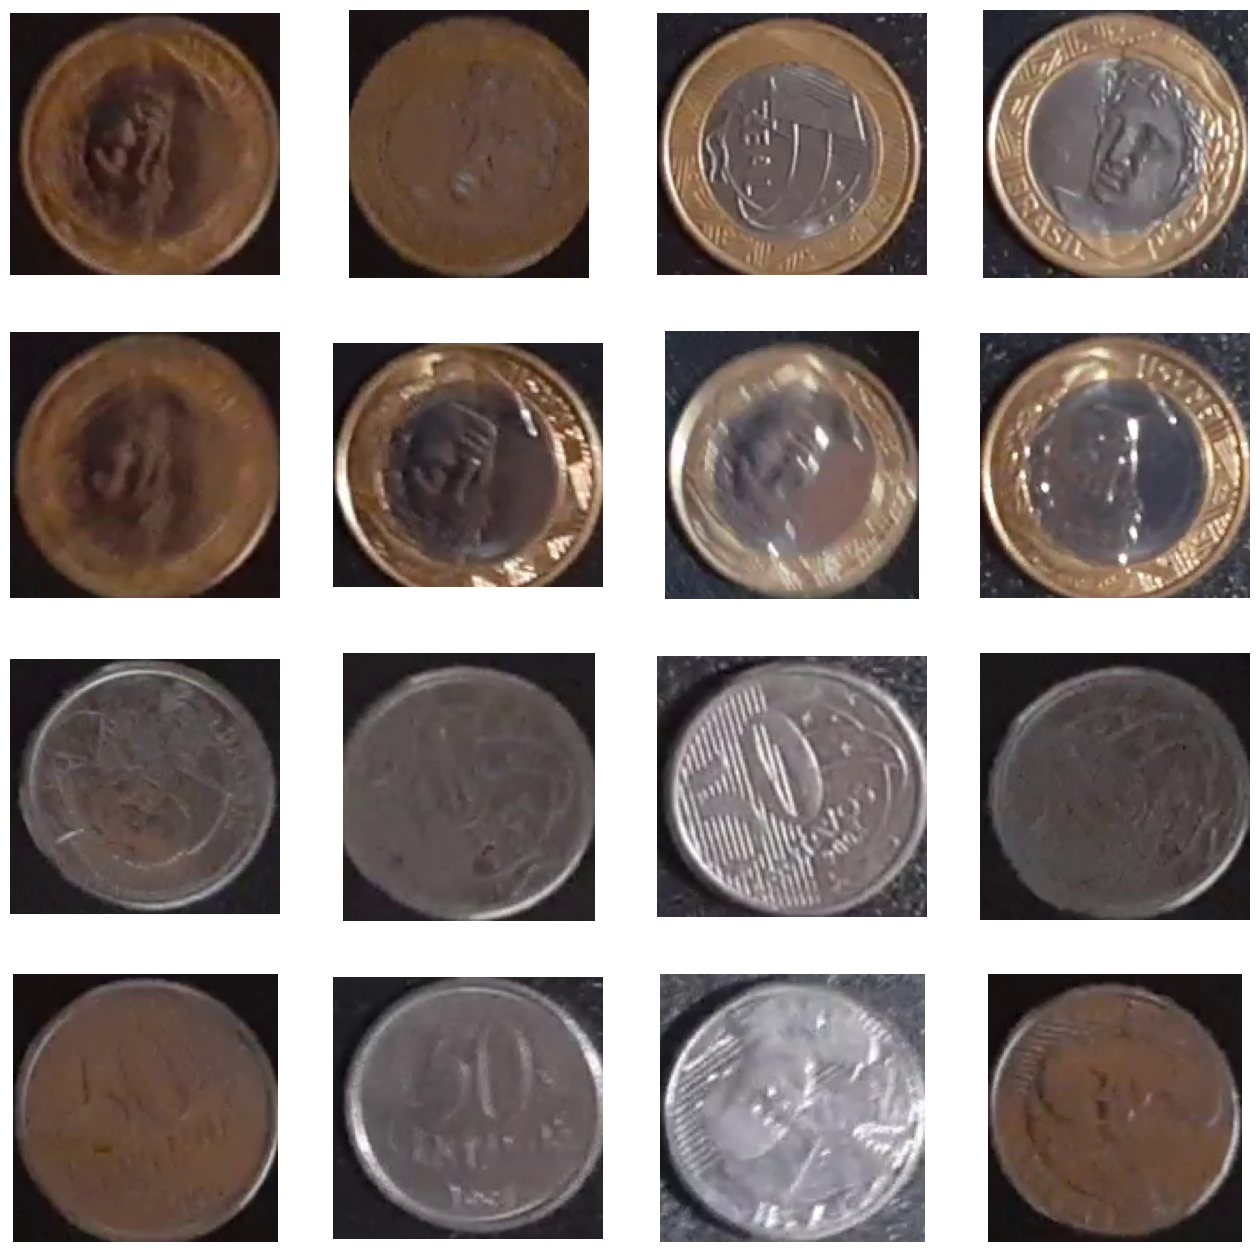

In [4]:
#@title Show some coins
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
nrows = 4
ncols = 4
# Directory with our training 050 pictures
train_050_dir = os.path.join(train_dir, '050')
# Directory with our training 100 pictures
train_100_dir = os.path.join(train_dir, '100')
train_100_fnames = os.listdir(train_100_dir)
train_050_fnames = os.listdir(train_050_dir)
pic_index = 0 # Index for iterating over images
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
pic_index += 8
next_100_pix = [os.path.join(train_100_dir, fname)
                for fname in train_100_fnames[pic_index-8:pic_index]]
next_050_pix = [os.path.join(train_050_dir, fname)
                for fname in train_050_fnames[pic_index-8:pic_index]]
for i, img_path in enumerate(next_100_pix+next_050_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

## Building a Small Convnet from Scratch

Resize all images to 100x100 pixels, so that will be the input size to the neural network.<p>
Define a **shallow** network (there are few training examples, easy to overfit if too much capacity).<p>
Notice that the actual purpose of the Conv layers is **extracting features to classify some coins** (we'll then do transfer learning for our UK coins). Define the final fully-connected layers in a separate step.<p>
# From Keras.io
You might wish to add regularization to some layers as well, to do so plesae check: https://keras.io/api/layers/regularizers/
Regularizers allow you to apply penalties on layer parameters or layer activity during optimization. These penalties are summed into the loss function that the network optimizes.

Regularization penalties are applied on a per-layer basis. The exact API will depend on the layer, but many layers (e.g. Dense, Conv1D, Conv2D and Conv3D) have a unified API.

These layers expose 3 keyword arguments:

    kernel_regularizer: Regularizer to apply a penalty on the layer's kernel
    bias_regularizer: Regularizer to apply a penalty on the layer's bias
    activity_regularizer: Regularizer to apply a penalty on the layer's output


# Clear Keras backend to try new model (Only do this if you want to change model parameters)



In [28]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Reinitialize your model from scratch
model = None  # Explicitly set to None
UKmodel = None  # Explicitly set to None
# Clear the current TensorFlow graph
K.clear_session(free_memory=True)



In [5]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import regularizers #for regularization

2025-03-29 16:30:35.105822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743265835.117459   48468 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743265835.120975   48468 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743265835.133131   48468 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743265835.133146   48468 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743265835.133147   48468 computation_placer.cc:177] computation placer alr

In [6]:
# Input feature map is 100x100x3 colour channels
# img_input = layers.Input(shape=(100, 100, 3))
# #ADD INTERMEDIATE CONV + POOLING LAYERS
# #DON'T ADD FINAL LAYERS AT THIS STEP, USE THE NEXT ONE

img_input = layers.Input(shape=(100, 100, 3))
# Keep the training on only two layers to extract only generalized features like shapes and edges and such, prevent overfitting

x = layers.Conv2D(16, (5, 5), activation='relu')(img_input) # first layer takes image in, finds features (16 filters/kernels)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(32, (3, 3), activation='relu')(x)         # second layer looks at the output of first layer (32 filters)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu')(x)         # 3rd layer as above 64 filters
x = layers.MaxPooling2D((2, 2))(x)

#x = layers.Conv2D(128, (3, 3), activation='relu')(x)         # 4th layer as above 128 filters
#x = layers.MaxPooling2D((2, 2))(x)



I0000 00:00:1743265841.117445   48468 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9598 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


Now **flatten** the feature map and add a couple dense (fully connected) layers. The final one needs **5 outputs** as we're doing a 5-class classification.<p>
<u>We can no longer use a sigmoid output</u> (that handles only 2 classes). See aother vailable activations in https://keras.io/api/layers/activations/
You can add regularization, and also dropout right before the final layer to improve generalization (reduce overfitting)

In [7]:




# # OUTPUT LAYERS NEEDS 5 NODES (one per class). 'sigmoid' ACTIVATION NO LONGER SUITABLE
# # Create model:
# model = Model(img_input, output)

# # Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# # ADD HIDDEN AND FINAL DENSE LAYERS
x = layers.Dense(64, activation='relu')(x) # reduce numper of neurons due to small network
# Final layer with 5 "neurons" one for each class
output = layers.Dense(5, activation='softmax')(x)

# Create model:
model = Model(img_input, output)


Let's summarize the model architecture. NOTICE THE LAYER NAMES, you'll need them later on:

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 434,341 (1.66 MB)

 Trainable params: 434,341 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

Next, we'll configure the specifications for model training, using Keras [model.compile](https://keras.io/api/models/model_training_apis/#compile-method) method.<p>
Don't train our model with the `binary_crossentropy` loss, because the final activation cannot be a sigmoid. Check https://keras.io/api/losses/ for alternative **loss** metrics suitable for your new activation.<p>
We can use RMSprop optimizer algorithm `rmsprop`, learning rate commonly 0.001. During training, we will want to monitor classification accuracy. Other available optimizers: https://keras.io/api/optimizers/

In [9]:
from tensorflow.keras.optimizers import RMSprop
# use categorical crossentropy losss
model.compile(loss='categorical_crossentropy', # Multi-class classification
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels 0, 1, 2, ... corresponding to each of the supplied subdirectories) to our network. As our data is split in train and validation folders, we need one generator for the training images and one for the validation images.<p>
Our generators will yield batches of B images and their labels.<p>
Preprocess the images by normalizing the pixel values to be in the `[0.0, 1.0]` range (dividing by 255.0). We can also benefit of **data augmentation** to account for more variability. Rotations are really important as new coins may appear rotated during future inference.<p>
In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class. To find out more augmentation options, check https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator. <p>
We also need to set class_mode to `categorical` (no longer `binary`)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# All images will be rescaled by 1./255 and augmented
train_datagen = ImageDataGenerator(
      rescale=1./255,           # Artificially increase the dataset by modifying the training data as belo:
      rotation_range=40,        #   Allow the NN to train on coins that are at different angles
      width_shift_range=0.2,    #   This helps the model learn to recognize coins even if they are not perfectly centered in the image.
      height_shift_range=0.2,   #   As above but vertically
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')      # fill empty pixels created after the shifts above with a copy of nearest pixel
val_datagen = ImageDataGenerator(rescale=1./255) #do not augment validation
B = 15 #Batch size
# Flow training images in batches of B using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size = (100, 100),  # All images will be resized to 100x100
        batch_size=B,
        # To use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')
# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(100, 100),
        batch_size=B,
        class_mode='categorical')

Found 765 images belonging to 5 classes.
Found 300 images belonging to 5 classes.


### Training
Let's train on all 765 images available, for 15 epochs, and validate on all 300 validation images. (This may take a few minutes to run).<p>
If the training accuracy is significantly better than validation accuracy, the model is overfitting, you should include regularization and dropout.


In [11]:
history = model.fit(
      train_generator,
      steps_per_epoch=765//B,  # 765 images = batch_size * steps
      epochs=20,
      validation_data=validation_generator,
      validation_steps=300//B,  # 300 images = batch_size * steps
      verbose=2)

Epoch 1/20


/home/alex/MengTB/ImProMaV/cw2/.Keras/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1743265867.561438   53631 service.cc:152] XLA service 0x7b1f78004dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743265867.561451   53631 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-03-29 16:31:07.582839: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743265867.697502   53631 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-29 16:31:07.901696: I e

51/51 - 4s - 85ms/step - acc: 0.2784 - loss: 1.5877 - val_acc: 0.3500 - val_loss: 1.4656
Epoch 2/20
51/51 - 2s - 37ms/step - acc: 0.4052 - loss: 1.4274 - val_acc: 0.5300 - val_loss: 1.1643
Epoch 3/20
51/51 - 2s - 37ms/step - acc: 0.4797 - loss: 1.2478 - val_acc: 0.4500 - val_loss: 1.3579
Epoch 4/20
51/51 - 2s - 38ms/step - acc: 0.5137 - loss: 1.1629 - val_acc: 0.5600 - val_loss: 0.9827
Epoch 5/20
51/51 - 2s - 37ms/step - acc: 0.5373 - loss: 1.0309 - val_acc: 0.5900 - val_loss: 0.9621
Epoch 6/20
51/51 - 2s - 38ms/step - acc: 0.5739 - loss: 1.0014 - val_acc: 0.6533 - val_loss: 0.7735
Epoch 7/20
51/51 - 2s - 38ms/step - acc: 0.5974 - loss: 0.9095 - val_acc: 0.5900 - val_loss: 1.0302
Epoch 8/20
51/51 - 2s - 38ms/step - acc: 0.6379 - loss: 0.8571 - val_acc: 0.4767 - val_loss: 1.6734
Epoch 9/20
51/51 - 2s - 37ms/step - acc: 0.6536 - loss: 0.8161 - val_acc: 0.6900 - val_loss: 0.6965
Epoch 10/20
51/51 - 2s - 37ms/step - acc: 0.6562 - loss: 0.7976 - val_acc: 0.7567 - val_loss: 0.6339
Epoch 11/2

---

#Now let's transfer this to our UK coins
We have a very limited collecton of UK coin examples (slightly above 300) split in 8 subdirectories, one for each  class. Let's apply transfer learning from our Brazilian coins.

In [ ]:
!wget https://edshare.gcu.ac.uk/id/document/61325 \
      -O /content/UK_coins_ClassSplit.zip

In [12]:
local_zip = '/content/UK_coins_ClassSplit.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('./')
# zip_ref.close()
UK_base_dir = './UK_coins_ClassSplit'

Take a look to some UK coin images:

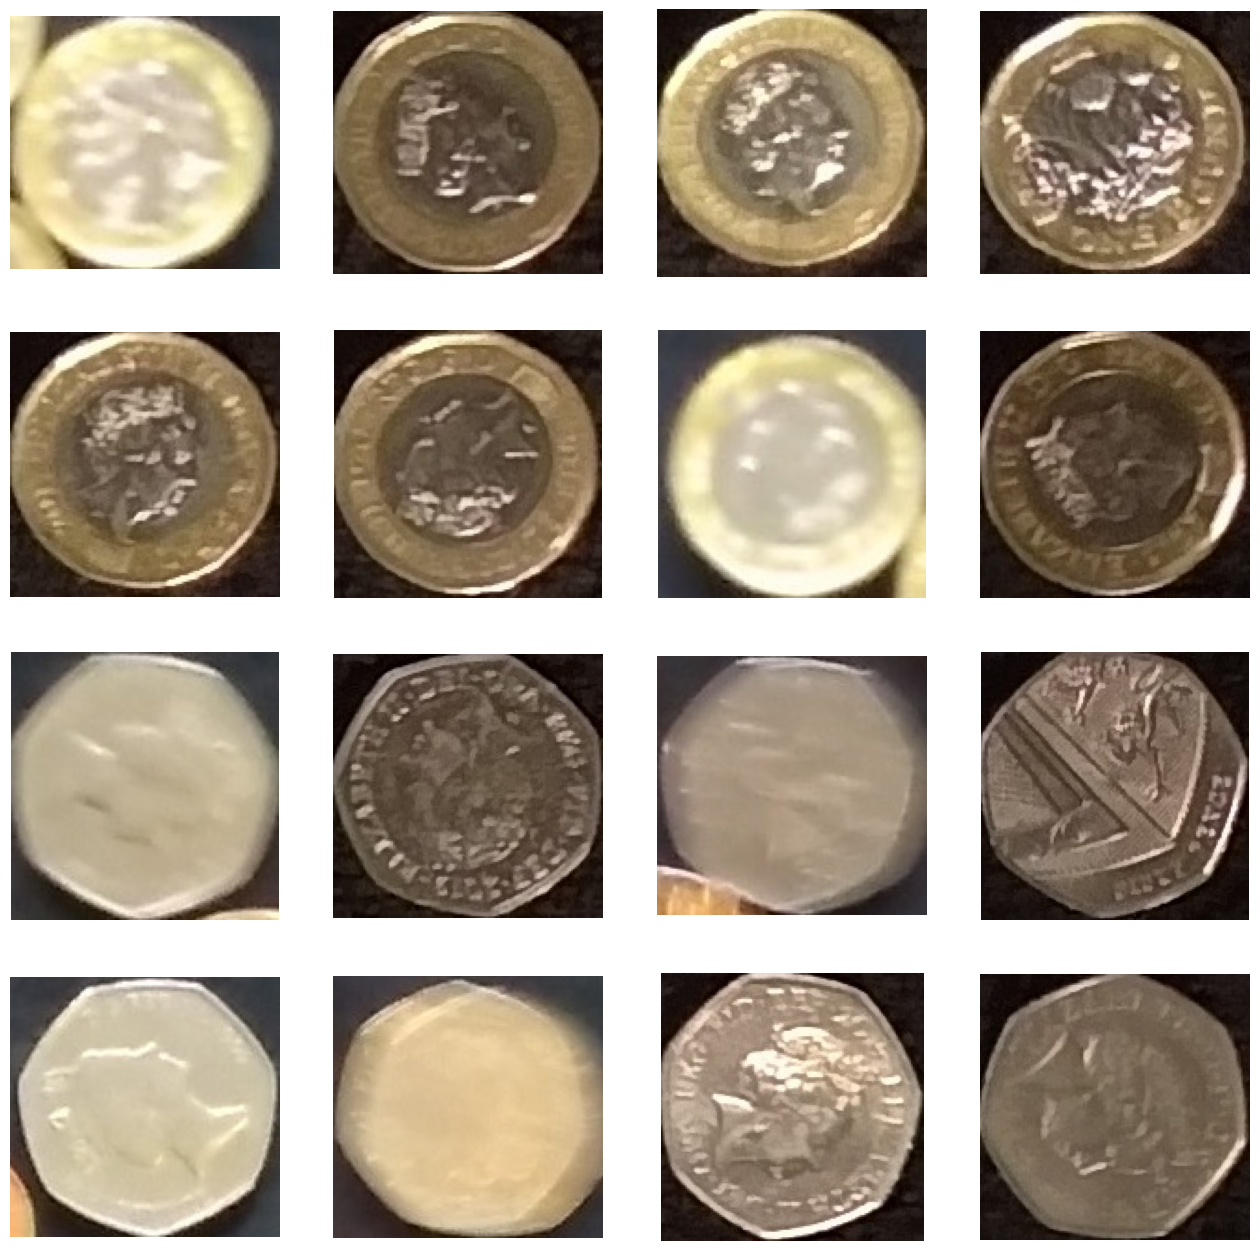

In [13]:
#@title Show some coins
import matplotlib.pyplot as plt
UK_100_dir = os.path.join(UK_base_dir, '100')
UK_050_dir = os.path.join(UK_base_dir, '050')
nrows = 4
ncols = 4
train_100_fnames = os.listdir(UK_100_dir)
train_050_fnames = os.listdir(UK_050_dir)
pic_index = 0 # Index for iterating over images
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
pic_index += 8
next_100_pix = [os.path.join(UK_100_dir, fname)
                for fname in train_100_fnames[pic_index-8:pic_index]]
next_050_pix = [os.path.join(UK_050_dir, fname)
                for fname in train_050_fnames[pic_index-8:pic_index]]
for i, img_path in enumerate(next_100_pix+next_050_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

Load the training data. Notice that this time the data is not pre-split in "train" and "validation" directories. We can do an automatic train/validation split as determined by parameter `validation_split`.<p>

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# All images will be rescaled by 1./255 and augmented
UK_datagen = ImageDataGenerator(rescale=1./255,
                                rotation_range=90, #degrees
                                validation_split=0.2)  #makes random split, 20% for validation
B = 10 #Batch size
# Extract flow training images in batches of B images
UK_train_generator = UK_datagen.flow_from_directory(
        UK_base_dir,  # This is the source directory for training images
        target_size = (100, 100),  # All images will be resized to 100x100
        batch_size=B,
        subset = 'training',
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')
# Extract flow validation images in batches of B images
UK_validation_generator = UK_datagen.flow_from_directory(
        UK_base_dir,
        target_size=(100, 100),
        batch_size=B,
        subset = 'validation',
        class_mode='categorical')

Found 250 images belonging to 8 classes.
Found 59 images belonging to 8 classes.


Now we freeze all layers of our Brazilian CNN, so they don't get re-trained:

In [15]:
for layer in model.layers:
  print('freezing ' + layer.name)
  layer.trainable = False

freezing input_layer
freezing conv2d
freezing max_pooling2d
freezing conv2d_1
freezing max_pooling2d_1
freezing conv2d_2
freezing max_pooling2d_2
freezing flatten
freezing dense
freezing dense_1


Next, replace the last FC layers (right after flattening) by new ones. **Output now needs 8 classes!**<p>
Check the layer names to select the desired replacement point.

In [16]:
replace_point = model.get_layer('flatten')
x = replace_point.output
#x = layers.Dense(128, activation='relu')(x) # 256 might be too many neurons
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x) # reduce from 128
x = layers.Dropout(0.6)(x)                  #  prevent overfitting with a dropout
UKoutput = layers.Dense(8, activation='softmax')(x)

UKmodel = Model(img_input, UKoutput)

Get a summary of the updated  UK model. Is should show a number of non-trainable parameters (those from the frozen layers). The transferred layers should have the same names they had in the original model, added layers will get new names.

In [17]:
UKmodel.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 434,536 (1.66 MB)

 Trainable params: 410,184 (1.56 MB)

 Non-trainable params: 24,352 (95.12 KB)

Compile the new model. Remember that we need to use a reduced learning rate (like 1/10 of the original one)

In [18]:
UKmodel.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001), # Reduced learning rate
              metrics=['acc'])

Train the added layers on our UK coins. We are assuming that the Brazilian coin features extracted by the frozen layers will also be useful for the UK coins...

In [19]:
history = UKmodel.fit(
      UK_train_generator,
      steps_per_epoch=250//B,  # 250 train images = batch_size * steps
      epochs=40,
      validation_data=UK_validation_generator,
      validation_steps=59//B,  # 59 validation images = batch_size * steps
      verbose=2)

Epoch 1/40


2025-03-29 16:37:10.621871: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.9 = (f32[10,16,96,96]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,3,100,100]{3,2,1,0} %bitcast.3252, f32[16,3,5,5]{3,2,1,0} %bitcast.3259, f32[16]{0} %bitcast.3261), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/conv2d_1/convolution" source_file="/home/alex/MengTB/ImProMaV/cw2/.Keras/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-03-29 16:37:10.645137: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted pote

25/25 - 3s - 101ms/step - acc: 0.2360 - loss: 2.1200 - val_acc: 0.4800 - val_loss: 2.0057
Epoch 2/40
25/25 - 1s - 23ms/step - acc: 0.3400 - loss: 1.9868 - val_acc: 0.4800 - val_loss: 1.9052
Epoch 3/40
25/25 - 1s - 22ms/step - acc: 0.3400 - loss: 1.8702 - val_acc: 0.5200 - val_loss: 1.7738
Epoch 4/40
25/25 - 1s - 22ms/step - acc: 0.4040 - loss: 1.7773 - val_acc: 0.4200 - val_loss: 1.7170
Epoch 5/40
25/25 - 1s - 22ms/step - acc: 0.4000 - loss: 1.7777 - val_acc: 0.4400 - val_loss: 1.6550
Epoch 6/40
25/25 - 1s - 22ms/step - acc: 0.3920 - loss: 1.7339 - val_acc: 0.4000 - val_loss: 1.6332
Epoch 7/40
25/25 - 1s - 22ms/step - acc: 0.4040 - loss: 1.6449 - val_acc: 0.4200 - val_loss: 1.6025
Epoch 8/40
25/25 - 1s - 22ms/step - acc: 0.3760 - loss: 1.6413 - val_acc: 0.4200 - val_loss: 1.5632
Epoch 9/40
25/25 - 1s - 23ms/step - acc: 0.4320 - loss: 1.5967 - val_acc: 0.4000 - val_loss: 1.5144
Epoch 10/40
25/25 - 1s - 23ms/step - acc: 0.4040 - loss: 1.6087 - val_acc: 0.4400 - val_loss: 1.5093
Epoch 11/

You might try to improve a bit by unfreezing the last imported Conv layer as well, and retrain some more with a heavily reduced learning rate (1/100 of the original)<p>
Check the layers names and update them as needed.

In [21]:
unfreeze = False
for layer in UKmodel.layers:
  if layer.name == 'conv2d_1': #first layer to unfreeze
    print('--- unfreezing ---')
    unfreeze = True
  if unfreeze:
    layer.trainable = True
  print(layer.name)

input_layer
conv2d
max_pooling2d
--- unfreezing ---
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
flatten
dense_2
dropout
dense_3


In [23]:
#show model again. Compare thenumber of non-trainable parameters with previous versions
UKmodel.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 844,722 (3.22 MB)

 Trainable params: 433,320 (1.65 MB)

 Non-trainable params: 1,216 (4.75 KB)

 Optimizer params: 410,186 (1.56 MB)

Finally, fine-tune with Stochastic Gradient Descent with very low learning rate for 50 epochs

In [24]:
# As an optimizer, here we will use SGD
# with a very low learning rate (0.00001)
from tensorflow.keras.optimizers import SGD
UKmodel.compile(loss='categorical_crossentropy',
                optimizer=SGD(learning_rate=0.001/100, momentum=0.9),
                metrics=['acc'])

In [25]:
history = UKmodel.fit(
      UK_train_generator,
      steps_per_epoch=250//B,  # 221 images = batch_size * steps
      epochs=50,
      validation_data=UK_validation_generator,
      validation_steps=59//B,  # 88 images = batch_size * steps
      verbose=2)

Epoch 1/50


2025-03-29 16:38:53.491474: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.10 = (f32[10,32,46,46]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,16,48,48]{3,2,1,0} %bitcast.4120, f32[32,16,3,3]{3,2,1,0} %bitcast.3926, f32[32]{0} %bitcast.4325), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/conv2d_1_2/convolution" source_file="/home/alex/MengTB/ImProMaV/cw2/.Keras/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-03-29 16:38:53.512269: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted p

25/25 - 3s - 108ms/step - acc: 0.5760 - loss: 1.1831 - val_acc: 0.5800 - val_loss: 1.1728
Epoch 2/50
25/25 - 1s - 22ms/step - acc: 0.5840 - loss: 1.1978 - val_acc: 0.6000 - val_loss: 1.1433
Epoch 3/50
25/25 - 1s - 22ms/step - acc: 0.5200 - loss: 1.2185 - val_acc: 0.6000 - val_loss: 1.1104
Epoch 4/50
25/25 - 1s - 22ms/step - acc: 0.5720 - loss: 1.1948 - val_acc: 0.5200 - val_loss: 1.1536
Epoch 5/50
25/25 - 1s - 22ms/step - acc: 0.5200 - loss: 1.2200 - val_acc: 0.5800 - val_loss: 1.1857
Epoch 6/50
25/25 - 1s - 22ms/step - acc: 0.5320 - loss: 1.1509 - val_acc: 0.6000 - val_loss: 1.1370
Epoch 7/50
25/25 - 1s - 22ms/step - acc: 0.5800 - loss: 1.1566 - val_acc: 0.5600 - val_loss: 1.1354
Epoch 8/50
25/25 - 1s - 22ms/step - acc: 0.5560 - loss: 1.2083 - val_acc: 0.6200 - val_loss: 1.0914
Epoch 9/50
25/25 - 1s - 22ms/step - acc: 0.5640 - loss: 1.1885 - val_acc: 0.6000 - val_loss: 1.1075
Epoch 10/50
25/25 - 1s - 22ms/step - acc: 0.6240 - loss: 1.1486 - val_acc: 0.5800 - val_loss: 1.0979
Epoch 11/

^^ everything was tried so need a new approach::: use a pretrained model that's much larger

# Inference
That should be the classifier ready. If you wish, try to play inference on a new image using UKmodel.predict
https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict

In [26]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
#upload a new coin image and try to classify it
fname = "./200_hard_065.jpg" #update name as needed
img = load_img(fname, target_size=(100, 100))
x = img_to_array(img)  # Numpy array with shape (100, 100, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 100, 100, 3)
# Rescale by 1/255
x /= 255
# Let's run our image through our network
prediction = UKmodel.predict(x)
prediction
#class numbers corresponds to subdirectories (train_datagen.flow_from_directory uses alphabetic order by default)

FileNotFoundError: [Errno 2] No such file or directory: './200_hard_065.jpg'

In [ ]:
# First, print out the class indices to understand which index corresponds to which coin value:
print(UK_train_generator.class_indices)
# Find the index of the highest confidence prediction
predicted_class_index = np.argmax(prediction)
print(f"Predicted class index: {predicted_class_index}")
# Convert the raw prediction to a more readable format:
print("Prediction probabilities:")
for class_name, prob in zip(UK_train_generator.class_indices.keys(), prediction[0]):
    print(f"{class_name}: {prob:.4f}")

# Following code is for Pool Size calculation

In [ ]:
# pool size calculation
# Initial input size
input_size = 100  # original input image size

# For a 3x3 Conv2D with no padding
def calculate_conv_output(input_size, kernel_size=3, stride=1):
    return (input_size - kernel_size + 1) // stride

# For a 2x2 MaxPooling2D
def calculate_pool_output(input_size, pool_size=2, stride=2):
    return input_size // pool_size

# Example calculation
current_size = 100
print("Starting size:", current_size)

# First Conv2D + MaxPool
current_size = calculate_pool_output(calculate_conv_output(current_size, kernel_size=5))
print("After first layer:", current_size)

# Second Conv2D + MaxPool
current_size = calculate_pool_output(calculate_conv_output(current_size))
print("After second layer:", current_size)

# 3rd Conv2D + MaxPool
current_size = calculate_pool_output(calculate_conv_output(current_size))
print("After 3rd layer:", current_size)

# 4th Conv2D + MaxPool
current_size = calculate_pool_output(calculate_conv_output(current_size))
print("After 4th layer:", current_size)